In [2]:
from torch.utils import data
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from PIL import Image
import torch
import os
import random

def get_loader(image_dir, image_size=128,batch_size=16, mode='train', num_workers=0,random=True):
    """Build and return a data loader."""
    transform = []

    transform.append(T.Resize((image_size,image_size)))
    transform.append(T.Grayscale(num_output_channels=1))
    if random:
        transform.append(T.RandomAffine(degrees=10, translate=(0.0,0.0), scale=(0.8,1), shear=5,fill=(255), interpolation=Image.Resampling.BICUBIC))
    transform.append(T.ToTensor())
    # transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform.append(T.Normalize(mean=(0.5), std=(0.5)))
    
    # transform.append(T.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.8,0.1), shear=20,fill=(1,1,1)))

    transform = T.Compose(transform)
    
    dataset = ImageFolder(image_dir, transform)

    data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=(mode=='train'), num_workers=num_workers)
    
    return data_loader


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Setting up tensorboard (real-time logging)

In [5]:
import tensorflow as tf

class Logger(object):
    """Tensorboard logger."""

    def __init__(self, log_dir):
        """Initialize summary writer."""
        self.writer = tf.summary.create_file_writer(log_dir)

    def scalar_summary(self, tag, value, step):
        """Add scalar summary."""
        with self.writer.as_default():
            tf.summary.scalar(name=tag, data=value, step=step)
            self.writer.flush()


2025-06-19 11:54:42.608222: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-19 11:54:42.615927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750314282.625061 1160828 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750314282.627854 1160828 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750314282.634945 1160828 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [6]:
"""
#create sample log for testing

import os

# Example directory for TensorBoard logs
log_dir = "./log/sampletest"
os.makedirs(log_dir, exist_ok=True)

# Initialize Logger
logger = Logger(log_dir=log_dir)

# Create a simple loop to log some values
for step in range(10):
    value = step * 2  # Example scalar value
    logger.scalar_summary(tag="sample_test", value=value, step=step)"""

'\n#create sample log for testing\n\nimport os\n\n# Example directory for TensorBoard logs\nlog_dir = "./log/sampletest"\nos.makedirs(log_dir, exist_ok=True)\n\n# Initialize Logger\nlogger = Logger(log_dir=log_dir)\n\n# Create a simple loop to log some values\nfor step in range(10):\n    value = step * 2  # Example scalar value\n    logger.scalar_summary(tag="sample_test", value=value, step=step)'

## Modified StarGAN architecture

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))

    def forward(self, x):
        return x + self.main(x)


class Generator(nn.Module):
    """Generator network."""
    def __init__(self, conv_dim=128, c_dim=16, repeat_num=6):
        super(Generator, self).__init__()

        layers = []
        layers.append(nn.Conv2d(1+c_dim, conv_dim, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(repeat_num):
            layers.append(ResidualBlock(dim_in=curr_dim, dim_out=curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 1, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        # Replicate spatially and concatenate domain information.
        # Note that this type of label conditioning does not work at all if we use reflection padding in Conv2d.
        # This is because instance normalization ignores the shifting (or bias) effect.
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        return self.main(x)


class Discriminator(nn.Module):
    """Discriminator network with PatchGAN."""
    def __init__(self, image_size=128, conv_dim=64, c_dim=16, repeat_num=6):
        super(Discriminator, self).__init__()
        layers = []
        layers.append(nn.Conv2d(1, conv_dim, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.01))

        curr_dim = conv_dim
        for i in range(1, repeat_num):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01))
            curr_dim = curr_dim * 2

        kernel_size = int(image_size / np.power(2, repeat_num))
        self.main = nn.Sequential(*layers)
        self.conv1 = nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(curr_dim, c_dim, kernel_size=kernel_size, bias=False)
        
    def forward(self, x):
        h = self.main(x)
        out_src = self.conv1(h)
        out_cls = self.conv2(h)
        return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class TxtImageDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        self.samples = []
        labels_set = set()
        with open(txt_file, 'r') as f:
            for line in f:
                img_path, label = line.strip().split(',')
                label = int(label.strip())
                self.samples.append((img_path.strip(), label))
                labels_set.add(label)
        # Remap labels to 0...N-1
        self.label2idx = {label: idx for idx, label in enumerate(sorted(labels_set))}
        self.samples = [(img, self.label2idx[label]) for img, label in self.samples]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img_full_path = os.path.join(self.root_dir, img_path)
        image = Image.open(img_full_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, label

def get_txt_loader(txt_file, root_dir, image_size=128, batch_size=16, mode='train', num_workers=0):
    from torchvision import transforms as T
    transform = T.Compose([
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(mean=(0.5,), std=(0.5,))
    ])
    dataset = TxtImageDataset(txt_file, root_dir, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=(mode=='train'), num_workers=num_workers)
    return loader

## Modified VAE architecture

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, img_channels=1, img_size=128, num_classes=16, z_dim=128):
        super(CVAE, self).__init__()
        self.img_size = img_size
        self.z_dim = z_dim
        self.num_classes = num_classes

        # Encoder: input is image + label (as one-hot, spatially broadcast)
        self.enc_conv = nn.Sequential(
            nn.Conv2d(img_channels + num_classes, 32, 4, 2, 1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),  # 8x8
            nn.ReLU(),
            nn.Flatten()
        )
        flat_dim = 256 * (img_size // 16) * (img_size // 16)
        self.fc_mu = nn.Linear(flat_dim, z_dim)
        self.fc_logvar = nn.Linear(flat_dim, z_dim)

        # Decoder: input is z + label
        self.fc_dec = nn.Linear(z_dim + num_classes, flat_dim)
        self.dec_conv = nn.Sequential(
            nn.Unflatten(1, (256, img_size // 16, img_size // 16)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, img_channels, 4, 2, 1),  # 128x128
            nn.Sigmoid()
        )

    def encode(self, x, y):
        # y: (batch, num_classes) -> (batch, num_classes, H, W)
        y_img = y[:, :, None, None].expand(-1, -1, x.size(2), x.size(3))
        x_in = torch.cat([x, y_img], dim=1)
        h = self.enc_conv(x_in)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        zy = torch.cat([z, y], dim=1)
        h = self.fc_dec(zy)
        x_hat = self.dec_conv(h)
        return x_hat

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z, y)
        return x_hat, mu, logvar

## Training of the CVAE

In [ ]:
# --- Training the CVAE ---

import torch
import torch.nn.functional as F
from tqdm import tqdm

# Prepare dataloader
train_loader = get_txt_loader(
    txt_file='dataset/train.txt',
    root_dir='dataset',
    image_size=128,
    batch_size=4,  
    num_workers=4
)

# Dynamically get number of classes
num_classes = len(train_loader.dataset.label2idx)

# Model, optimizer, device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(img_channels=1, img_size=128, num_classes=num_classes, z_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Loss function for CVAE
def cvae_loss(x_hat, x, mu, logvar):
    recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kld, recon_loss, kld

import torch
torch.cuda.empty_cache()

# Training loop
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss, total_recon, total_kld = 0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images = images.to(device)
        labels = F.one_hot(labels, num_classes=num_classes).float().to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(images, labels)
        loss, recon, kld = cvae_loss(x_hat, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_recon += recon.item()
        total_kld += kld.item()
    print(f"Epoch {epoch+1}: Loss={total_loss:.2f}, Recon={total_recon:.2f}, KLD={total_kld:.2f}")

# Save model
torch.save(model.state_dict(), "cvae_kagunita.pth")

/tmp/ipykernel_1160828/755762130.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cvae_kagunita.pth", map_location=device))


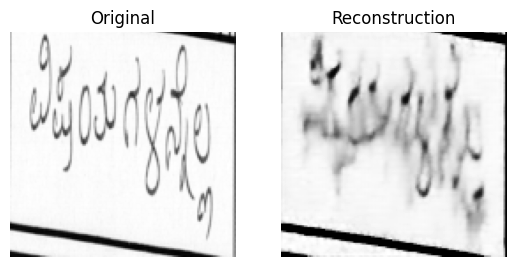

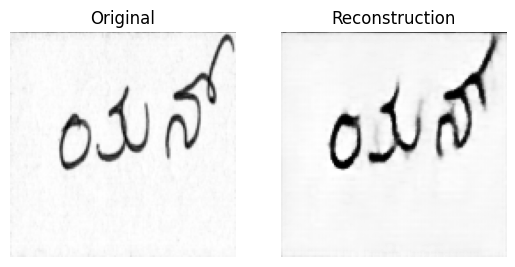

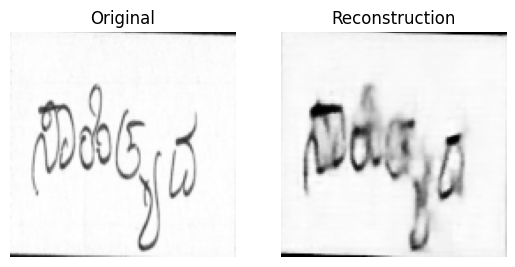

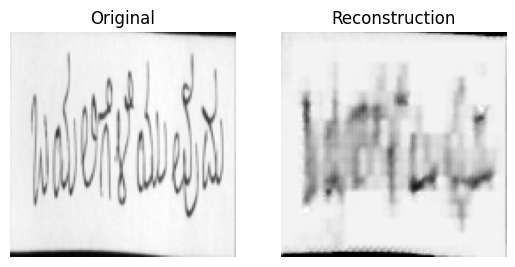

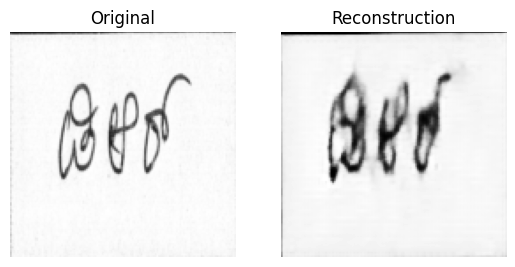

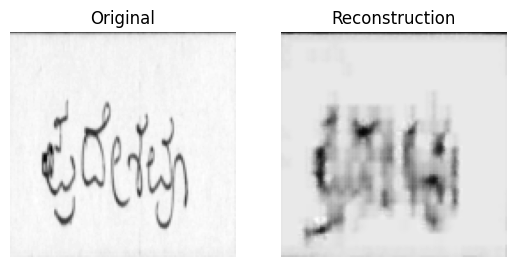

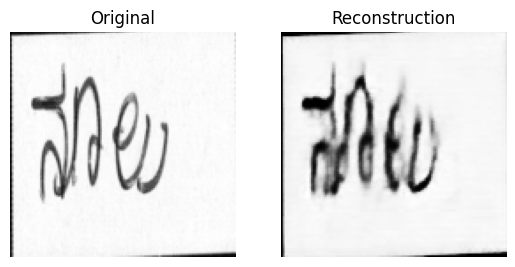

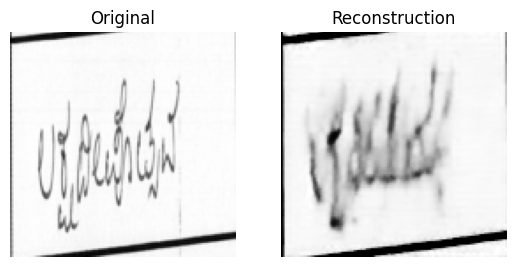

Average Loss: 573.2811, Recon: 493.1961, KLD: 80.0850


In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


# Load train data
train_loader = get_txt_loader(
    txt_file='dataset/train.txt',
    root_dir='dataset',
    image_size=128,
    batch_size=8,
    mode='train',
    num_workers=0
)

num_classes = len(train_loader.dataset.label2idx)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = CVAE(img_channels=1, img_size=128, num_classes=num_classes, z_dim=128).to(device)
model.load_state_dict(torch.load("cvae_kagunita.pth", map_location=device))
model.eval()

def cvae_loss(x_hat, x, mu, logvar):
    recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kld, recon_loss, kld

total_loss, total_recon, total_kld, n_batches = 0, 0, 0, 0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels_oh = F.one_hot(labels, num_classes=num_classes).float().to(device)
        x_hat, mu, logvar = model(images, labels_oh)
        loss, recon, kld = cvae_loss(x_hat, images, mu, logvar)
        total_loss += loss.item()
        total_recon += recon.item()
        total_kld += kld.item()
        n_batches += 1

        # Show a few images
        if batch_idx < 2:
            for i in range(min(4, images.size(0))):
                orig = images[i].cpu().numpy().squeeze()
                recon_img = x_hat[i].cpu().numpy().squeeze()
                fig, axs = plt.subplots(1, 2)
                axs[0].imshow(orig, cmap='gray')
                axs[0].set_title('Original')
                axs[1].imshow(recon_img, cmap='gray')
                axs[1].set_title('Reconstruction')
                for ax in axs:
                    ax.axis('off')
                plt.show()
        if batch_idx == 4:
            break

print(f"Average Loss: {total_loss/n_batches:.4f}, Recon: {total_recon/n_batches:.4f}, KLD: {total_kld/n_batches:.4f}")

## Solver for training and testing:

## Config and Run

In [12]:
# --- Training the CVAE ---

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ----------------- Data Loader -----------------
class TxtImageDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        self.samples = []
        labels_set = set()
        with open(txt_file, 'r') as f:
            for line in f:
                img_path, label = line.strip().split(',')
                label = int(label.strip())
                self.samples.append((img_path.strip(), label))
                labels_set.add(label)
        # Remap labels to 0...N-1
        self.label2idx = {label: idx for idx, label in enumerate(sorted(labels_set))}
        self.samples = [(img, self.label2idx[label]) for img, label in self.samples]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img_full_path = os.path.join(self.root_dir, img_path)
        image = Image.open(img_full_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, label

def get_txt_loader(txt_file, root_dir, image_size=128, batch_size=16, mode='train', num_workers=0):
    from torchvision import transforms as T
    transform = T.Compose([
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(mean=(0.5,), std=(0.5,))
    ])
    dataset = TxtImageDataset(txt_file, root_dir, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=(mode=='train'), num_workers=num_workers)
    return loader

# ----------------- CVAE Model -----------------
class CVAE(nn.Module):
    def __init__(self, img_channels=1, img_size=128, num_classes=16, z_dim=128):
        super(CVAE, self).__init__()
        self.img_size = img_size
        self.z_dim = z_dim
        self.num_classes = num_classes

        # Encoder: input is image + label (as one-hot, spatially broadcast)
        self.enc_conv = nn.Sequential(
            nn.Conv2d(img_channels + num_classes, 32, 4, 2, 1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),  # 8x8
            nn.ReLU(),
            nn.Flatten()
        )
        flat_dim = 256 * (img_size // 16) * (img_size // 16)
        self.fc_mu = nn.Linear(flat_dim, z_dim)
        self.fc_logvar = nn.Linear(flat_dim, z_dim)

        # Decoder: input is z + label
        self.fc_dec = nn.Linear(z_dim + num_classes, flat_dim)
        self.dec_conv = nn.Sequential(
            nn.Unflatten(1, (256, img_size // 16, img_size // 16)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, img_channels, 4, 2, 1),  # 128x128
            nn.Sigmoid()
        )

    def encode(self, x, y):
        y_img = y[:, :, None, None].expand(-1, -1, x.size(2), x.size(3))
        x_in = torch.cat([x, y_img], dim=1)
        h = self.enc_conv(x_in)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        zy = torch.cat([z, y], dim=1)
        h = self.fc_dec(zy)
        x_hat = self.dec_conv(h)
        return x_hat

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z, y)
        return x_hat, mu, logvar

def cvae_loss(x_hat, x, mu, logvar):
    recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kld, recon_loss, kld

def reconstruction_accuracy(x_hat, x, threshold=0.1):
    x_bin = (x > 0.5).float()
    x_hat_bin = (x_hat > 0.5).float()
    correct = (x_bin == x_hat_bin).float().sum()
    total = torch.numel(x)
    return (correct / total).item() * 100

# ----------------- Training (if needed) -----------------
# train_loader = get_txt_loader('dataset/train.txt', 'dataset', image_size=128, batch_size=4, num_workers=4)
# num_classes = len(train_loader.dataset.label2idx)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CVAE(img_channels=1, img_size=128, num_classes=num_classes, z_dim=128).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# epochs = 30
# for epoch in range(epochs):
#     model.train()
#     total_loss, total_recon, total_kld = 0, 0, 0
#     for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
#         images = images.to(device)
#         labels = F.one_hot(labels, num_classes=num_classes).float().to(device)
#         optimizer.zero_grad()
#         x_hat, mu, logvar = model(images, labels)
#         loss, recon, kld = cvae_loss(x_hat, images, mu, logvar)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#         total_recon += recon.item()
#         total_kld += kld.item()
#     print(f"Epoch {epoch+1}: Loss={total_loss:.2f}, Recon={total_recon:.2f}, KLD={total_kld:.2f}")
# torch.save(model.state_dict(), "cvae_kagunita.pth")

# ----------------- Test on Train Data -----------------
train_loader = get_txt_loader(
    txt_file='dataset/train.txt',
    root_dir='dataset',
    image_size=128,
    batch_size=16,
    mode='train',
    num_workers=0
)
num_classes = len(train_loader.dataset.label2idx)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(img_channels=1, img_size=128, num_classes=num_classes, z_dim=128).to(device)
model.load_state_dict(torch.load("cvae_kagunita.pth", map_location=device))
model.eval()

total_loss, total_recon, total_kld, n_batches, total_acc = 0, 0, 0, 0, 0
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels_oh = F.one_hot(labels, num_classes=num_classes).float().to(device)
        x_hat, mu, logvar = model(images, labels_oh)
        loss, recon, kld = cvae_loss(x_hat, images, mu, logvar)
        acc = reconstruction_accuracy(x_hat, images)
        total_loss += loss.item()
        total_recon += recon.item()
        total_kld += kld.item()
        total_acc += acc
        n_batches += 1
print(f"[Train] Set size: {len(train_loader.dataset)} samples")
print(f"[Train] Average Loss: {total_loss/n_batches:.4f}")
print(f"[Train] Average Recon Loss: {total_recon/n_batches:.4f}")
print(f"[Train] Average KLD: {total_kld/n_batches:.4f}")
print(f"[Train] Average Reconstruction Accuracy: {total_acc/n_batches:.2f}%")

# ----------------- Test on Test Data (with label mapping) -----------------
test_loader = get_txt_loader(
    txt_file='dataset/test.txt',
    root_dir='dataset',
    image_size=128,
    batch_size=16,
    mode='test',
    num_workers=0
)
# Use train label2idx for test mapping
train_label2idx = train_loader.dataset.label2idx
class RemappedTestDataset(torch.utils.data.Dataset):
    def __init__(self, orig_dataset, train_label2idx):
        self.orig_dataset = orig_dataset
        self.train_label2idx = train_label2idx
        # Only keep samples whose label is in train_label2idx
        self.samples = [(img, label) for img, label in orig_dataset.samples if label in train_label2idx]
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img_full_path = os.path.join(self.orig_dataset.root_dir, img_path)
        image = Image.open(img_full_path).convert('L')
        if self.orig_dataset.transform:
            image = self.orig_dataset.transform(image)
        return image, self.train_label2idx[label]

test_loader.dataset = RemappedTestDataset(test_loader.dataset, train_label2idx)
num_classes_test = len(train_label2idx)

model = CVAE(img_channels=1, img_size=128, num_classes=num_classes_test, z_dim=128).to(device)
model.load_state_dict(torch.load("cvae_kagunita.pth", map_location=device))
model.eval()

total_loss, total_recon, total_kld, n_batches, total_acc = 0, 0, 0, 0, 0
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels_oh = F.one_hot(labels, num_classes=num_classes_test).float().to(device)
        x_hat, mu, logvar = model(images, labels_oh)
        loss, recon, kld = cvae_loss(x_hat, images, mu, logvar)
        acc = reconstruction_accuracy(x_hat, images)
        total_loss += loss.item()
        total_recon += recon.item()
        total_kld += kld.item()
        total_acc += acc
        n_batches += 1
print(f"[Test] Set size: {len(test_loader.dataset)} samples")
print(f"[Test] Average Loss: {total_loss/n_batches:.4f}")
print(f"[Test] Average Recon Loss: {total_recon/n_batches:.4f}")
print(f"[Test] Average KLD: {total_kld/n_batches:.4f}")
print(f"[Test] Average Reconstruction Accuracy: {total_acc/n_batches:.2f}%")

/tmp/ipykernel_1160828/798833058.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cvae_kagunita.pth", map_location=device))


[Train] Set size: 73517 samples
[Train] Average Loss: 580.7353
[Train] Average Recon Loss: 499.4393
[Train] Average KLD: 81.2960
[Train] Average Reconstruction Accuracy: 93.59%


ValueError: dataset attribute should not be set after DataLoader is initialized

In [13]:
# ----------------- Test on Test Data (with label mapping) -----------------
import torchvision
from torch.utils.data import DataLoader
from PIL import Image   
# Build test dataset and remap labels BEFORE creating DataLoader
test_dataset = TxtImageDataset(
    txt_file='dataset/test.txt',
    root_dir='dataset',
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((128, 128)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])
)

# Use train label2idx for test mapping
train_label2idx = train_loader.dataset.label2idx

class RemappedTestDataset(torch.utils.data.Dataset):
    def __init__(self, orig_dataset, train_label2idx):
        self.orig_dataset = orig_dataset
        self.train_label2idx = train_label2idx
        # Only keep samples whose label is in train_label2idx
        self.samples = [(img, label) for img, label in orig_dataset.samples if label in train_label2idx]
        self.root_dir = orig_dataset.root_dir
        self.transform = orig_dataset.transform
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img_full_path = os.path.join(self.root_dir, img_path)
        image = Image.open(img_full_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, self.train_label2idx[label]

remapped_test_dataset = RemappedTestDataset(test_dataset, train_label2idx)

test_loader = DataLoader(
    remapped_test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0
)

num_classes_test = len(train_label2idx)

model = CVAE(img_channels=1, img_size=128, num_classes=num_classes_test, z_dim=128).to(device)
model.load_state_dict(torch.load("cvae_kagunita.pth", map_location=device))
model.eval()

total_loss, total_recon, total_kld, n_batches, total_acc = 0, 0, 0, 0, 0
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels_oh = F.one_hot(labels, num_classes=num_classes_test).float().to(device)
        x_hat, mu, logvar = model(images, labels_oh)
        loss, recon, kld = cvae_loss(x_hat, images, mu, logvar)
        acc = reconstruction_accuracy(x_hat, images)
        total_loss += loss.item()
        total_recon += recon.item()
        total_kld += kld.item()
        total_acc += acc
        n_batches += 1
print(f"[Test] Set size: {len(remapped_test_dataset)} samples")
print(f"[Test] Average Loss: {total_loss/n_batches:.4f}")
print(f"[Test] Average Recon Loss: {total_recon/n_batches:.4f}")
print(f"[Test] Average KLD: {total_kld/n_batches:.4f}")
print(f"[Test] Average Reconstruction Accuracy: {total_acc/n_batches:.2f}%")



/tmp/ipykernel_1160828/2880710543.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cvae_kagunita.pth", map_location=device))


[Test] Set size: 13948 samples
[Test] Average Loss: 871.3044
[Test] Average Recon Loss: 788.0367
[Test] Average KLD: 83.2677
[Test] Average Reconstruction Accuracy: 91.27%


In [14]:
# ----------------- Test on Validation Data (with label mapping) -----------------
val_dataset = TxtImageDataset(
    txt_file='dataset/val.txt',
    root_dir='dataset',
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((128, 128)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])
)

remapped_val_dataset = RemappedTestDataset(val_dataset, train_label2idx)

val_loader = DataLoader(
    remapped_val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0
)

with torch.no_grad():
    total_loss, total_recon, total_kld, n_batches, total_acc = 0, 0, 0, 0, 0
    for images, labels in val_loader:
        images = images.to(device)
        labels_oh = F.one_hot(labels, num_classes=num_classes_test).float().to(device)
        x_hat, mu, logvar = model(images, labels_oh)
        loss, recon, kld = cvae_loss(x_hat, images, mu, logvar)
        acc = reconstruction_accuracy(x_hat, images)
        total_loss += loss.item()
        total_recon += recon.item()
        total_kld += kld.item()
        total_acc += acc
        n_batches += 1
print(f"[Val] Set size: {len(remapped_val_dataset)} samples")
print(f"[Val] Average Loss: {total_loss/n_batches:.4f}")
print(f"[Val] Average Recon Loss: {total_recon/n_batches:.4f}")
print(f"[Val] Average KLD: {total_kld/n_batches:.4f}")
print(f"[Val] Average Reconstruction Accuracy: {total_acc/n_batches:.2f}%")

[Val] Set size: 12263 samples
[Val] Average Loss: 845.3095
[Val] Average Recon Loss: 764.4770
[Val] Average KLD: 80.8324
[Val] Average Reconstruction Accuracy: 91.06%


/tmp/ipykernel_1160828/2306597624.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cvae_kagunita.pth", map_location=device))
Epoch 1/10

Epoch 1: Train Loss=567.2962, Test Recon Accuracy=91.25%


Epoch 2/10: 100%|██████████| 4595/4595 [23:29<00:00,  3.26it/s]


Epoch 2: Train Loss=556.7599, Test Recon Accuracy=91.17%


Epoch 3/10: 100%|██████████| 4595/4595 [23:30<00:00,  3.26it/s]


Epoch 3: Train Loss=550.3835, Test Recon Accuracy=91.21%


Epoch 4/10: 100%|██████████| 4595/4595 [23:30<00:00,  3.26it/s]


Epoch 4: Train Loss=543.9783, Test Recon Accuracy=91.29%


Epoch 5/10: 100%|██████████| 4595/4595 [23:30<00:00,  3.26it/s]


Epoch 5: Train Loss=538.8419, Test Recon Accuracy=91.11%


Epoch 6/10: 100%|██████████| 4595/4595 [23:31<00:00,  3.26it/s]


Epoch 6: Train Loss=533.6897, Test Recon Accuracy=91.16%


Epoch 7/10: 100%|██████████| 4595/4595 [23:31<00:00,  3.26it/s]


Epoch 7: Train Loss=529.0159, Test Recon Accuracy=90.88%


Epoch 8/10: 100%|██████████| 4595/4595 [23:29<00:00,  3.26it/s]


Epoch 8: Train Loss=524.3351, Test Recon Accuracy=90.97%


Epoch 9/10: 100%|██████████| 4595/4595 [23:32<00:00,  3.25it/s]


Epoch 9: Train Loss=520.1050, Test Recon Accuracy=90.78%


Epoch 10/10: 100%|██████████| 4595/4595 [23:31<00:00,  3.26it/s]


Epoch 10: Train Loss=515.5502, Test Recon Accuracy=90.90%


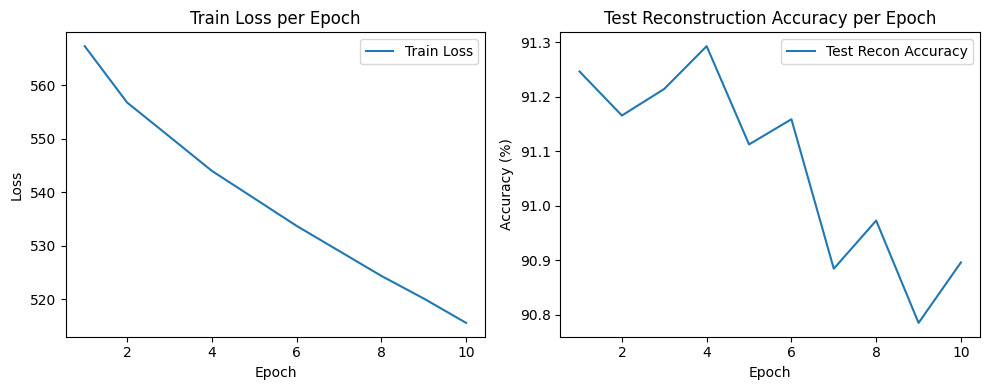

: 

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Data loaders ---
train_loader = get_txt_loader(
    txt_file='dataset/train.txt',
    root_dir='dataset',
    image_size=128,
    batch_size=16,
    mode='train',
    num_workers=0
)
test_loader = get_txt_loader(
    txt_file='dataset/test.txt',
    root_dir='dataset',
    image_size=128,
    batch_size=16,
    mode='test',
    num_workers=0
)
num_classes = len(train_loader.dataset.label2idx)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model ---
model = CVAE(img_channels=1, img_size=128, num_classes=num_classes, z_dim=128).to(device)
model.load_state_dict(torch.load("cvae_kagunita.pth", map_location=device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def cvae_loss(x_hat, x, mu, logvar):
    recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kld, recon_loss, kld

def reconstruction_accuracy(x_hat, x, threshold=0.1):
    x_bin = (x > 0.5).float()
    x_hat_bin = (x_hat > 0.5).float()
    correct = (x_bin == x_hat_bin).float().sum()
    total = torch.numel(x)
    return (correct / total).item() * 100

epochs = 10  # Reduce for faster plotting
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images = images.to(device)
        labels_oh = F.one_hot(labels, num_classes=num_classes).float().to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(images, labels_oh)
        loss, _, _ = cvae_loss(x_hat, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # Free up memory after each batch
        del images, labels_oh, x_hat, mu, logvar, loss
        torch.cuda.empty_cache()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Test Reconstruction Accuracy ---
    model.eval()
    total_acc, n_batches = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels_oh = F.one_hot(labels, num_classes=num_classes).float().to(device)
            x_hat, mu, logvar = model(images, labels_oh)
            acc = reconstruction_accuracy(x_hat, images)
            total_acc += acc
            n_batches += 1
            # Free up memory after each batch
            del images, labels_oh, x_hat, mu, logvar
            torch.cuda.empty_cache()
    avg_test_acc = total_acc / n_batches
    test_accuracies.append(avg_test_acc)
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Test Recon Accuracy={avg_test_acc:.2f}%")
    # Save model weights after every epoch
    torch.save(model.state_dict(), f"cvae_epoch_{epoch+1}.pth")
    torch.cuda.empty_cache()

# --- Plotting ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss per Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), test_accuracies, label='Test Recon Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Reconstruction Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Diffusion Model Implementation

We'll implement a Denoising Diffusion Probabilistic Model (DDPM) for generating images similar to your dataset.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

# --- Enhanced Diffusion Utilities for Serious Training ---
def cosine_beta_schedule(timesteps, s=0.008):
    """
    Cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    Better for high quality image generation
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    """Linear schedule - simpler but effective"""
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def quadratic_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    """Quadratic schedule - balanced approach"""
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps, dtype=torch.float64) ** 2

def sigmoid_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    """Sigmoid schedule - smooth transitions"""
    betas = torch.linspace(-6, 6, timesteps, dtype=torch.float64)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

def extract(a, t, x_shape):
    """Extract coefficients at specified timesteps and reshape for broadcasting"""
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

class EnhancedDiffusionUtils:
    def __init__(self, timesteps=1000, beta_schedule='cosine', device='cuda'):
        self.timesteps = timesteps
        self.device = device
        
        # Choose beta schedule
        if beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        elif beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'quadratic':
            betas = quadratic_beta_schedule(timesteps)
        elif beta_schedule == 'sigmoid':
            betas = sigmoid_beta_schedule(timesteps)
        else:
            raise ValueError(f"Unknown beta schedule: {beta_schedule}")
            
        # Convert to float32 for training efficiency
        self.betas = betas.float()
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        
        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        
        # Additional terms for improved sampling
        self.sqrt_alphas = torch.sqrt(self.alphas)
        self.sqrt_one_minus_alphas = torch.sqrt(1. - self.alphas)
        
        print(f"Diffusion setup complete:")
        print(f"- Timesteps: {timesteps}")
        print(f"- Beta schedule: {beta_schedule}")
        print(f"- Beta range: [{self.betas[0]:.6f}, {self.betas[-1]:.6f}]")
        print(f"- Alpha_cumprod range: [{self.alphas_cumprod[-1]:.6f}, {self.alphas_cumprod[0]:.6f}]")
        
    def q_sample(self, x_start, t, noise=None):
        """Sample from q(x_t | x_0) - the forward diffusion process"""
        if noise is None:
            noise = torch.randn_like(x_start)
            
        sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    def q_posterior_mean_variance(self, x_start, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior q(x_{t-1} | x_t, x_0)
        """
        posterior_mean_coef1 = extract(
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod), t, x_t.shape
        )
        posterior_mean_coef2 = extract(
            (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod), t, x_t.shape
        )
        posterior_mean = posterior_mean_coef1 * x_start + posterior_mean_coef2 * x_t
        
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(
            torch.log(torch.clamp(self.posterior_variance, min=1e-20)), t, x_t.shape
        )
        
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

# Initialize enhanced diffusion utilities
diffusion_utils = EnhancedDiffusionUtils(
    timesteps=1000, 
    beta_schedule='cosine',  # Best for image generation
    device=device if 'device' in globals() else 'cuda'
)

print("Enhanced diffusion utilities initialized successfully!")

Diffusion setup complete:
- Timesteps: 1000
- Beta schedule: cosine
- Beta range: [0.000100, 0.999900]
- Alpha_cumprod range: [0.000000, 0.999900]
Enhanced diffusion utilities initialized successfully!


In [5]:
# --- UNet Architecture for Diffusion ---
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
    def forward(self, x, t):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

class SimpleUnet(nn.Module):
    def __init__(self, image_channels=1, down_channels=(64, 128, 256, 512, 1024), 
                 up_channels=(1024, 512, 256, 128, 64), out_dim=1, time_emb_dim=32):
        super().__init__()
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        
        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) 
                                    for i in range(len(down_channels)-1)])
        
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) 
                                  for i in range(len(up_channels)-1)])

        # Edit: Corrected the output layer
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

# Test the model
model = SimpleUnet()
print("Model created successfully!")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test forward pass
x = torch.randn(2, 1, 128, 128)
t = torch.randint(0, 1000, (2,))
with torch.no_grad():
    out = model(x, t)
print(f"Input shape: {x.shape}")
print(f"Output shape: {out.shape}")

Model created successfully!
Number of parameters: 62,437,601
Input shape: torch.Size([2, 1, 128, 128])
Output shape: torch.Size([2, 1, 128, 128])
Input shape: torch.Size([2, 1, 128, 128])
Output shape: torch.Size([2, 1, 128, 128])


In [ ]:
# --- Enhanced Diffusion Model for Serious Training ---
class DiffusionModel(nn.Module):
    def __init__(self, unet_model, diffusion_utils, device):
        super().__init__()
        self.model = unet_model
        self.diffusion_utils = diffusion_utils
        self.device = device
        
        # Move diffusion utilities to device for better performance
        self.diffusion_utils.betas = self.diffusion_utils.betas.to(device)
        self.diffusion_utils.alphas = self.diffusion_utils.alphas.to(device)
        self.diffusion_utils.alphas_cumprod = self.diffusion_utils.alphas_cumprod.to(device)
        self.diffusion_utils.alphas_cumprod_prev = self.diffusion_utils.alphas_cumprod_prev.to(device)
        self.diffusion_utils.sqrt_alphas_cumprod = self.diffusion_utils.sqrt_alphas_cumprod.to(device)
        self.diffusion_utils.sqrt_one_minus_alphas_cumprod = self.diffusion_utils.sqrt_one_minus_alphas_cumprod.to(device)
        self.diffusion_utils.posterior_variance = self.diffusion_utils.posterior_variance.to(device)
        
    def forward(self, x_0):
        # Sample random timesteps
        t = torch.randint(0, self.diffusion_utils.timesteps, (x_0.shape[0],), device=self.device).long()
        # Sample noise
        noise = torch.randn_like(x_0)
        # Get noisy image
        x_t = self.diffusion_utils.q_sample(x_0, t, noise)
        # Predict noise
        noise_pred = self.model(x_t, t)
        return noise_pred, noise, t
    
    def loss(self, x_0):
        noise_pred, noise, t = self.forward(x_0)
        # Simple MSE loss - proven to work well for diffusion models
        return F.mse_loss(noise_pred, noise)
    
    @torch.no_grad()
    def sample(self, shape, num_inference_steps=50, guidance_scale=1.0):
        """Enhanced sampling with optional guidance"""
        # Start with random noise
        x = torch.randn(shape, device=self.device)
        
        # Create timestep schedule for sampling
        timesteps = torch.linspace(self.diffusion_utils.timesteps-1, 0, num_inference_steps, dtype=torch.long, device=self.device)
        
        for i, t in enumerate(timesteps):
            t_batch = t.repeat(shape[0])
            
            # Predict noise
            noise_pred = self.model(x, t_batch)
            
            # DDIM update step with improved numerical stability
            alpha_t = extract(self.diffusion_utils.alphas_cumprod, t_batch, x.shape)
            
            if t > 0:
                alpha_t_prev = extract(self.diffusion_utils.alphas_cumprod, (t-1).repeat(shape[0]), x.shape)
            else:
                alpha_t_prev = torch.ones_like(alpha_t)
            
            # Predict x_0 with better numerical stability
            pred_x0 = (x - torch.sqrt(1 - alpha_t) * noise_pred) / torch.sqrt(alpha_t)
            pred_x0 = torch.clamp(pred_x0, -1, 1)  # Clamp to valid range
            
            # Compute x_{t-1} using DDIM formula
            if t > 0:
                # DDIM step
                x = torch.sqrt(alpha_t_prev) * pred_x0 + torch.sqrt(1 - alpha_t_prev) * noise_pred
            else:
                x = pred_x0
                
        return x

# Initialize enhanced diffusion model with better settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check CUDA capabilities
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Available Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Create UNet with optimized architecture for 128x128 images
unet = SimpleUnet(
    image_channels=1, 
    down_channels=(64, 128, 256, 512, 1024),
    up_channels=(1024, 512, 256, 128, 64),
    out_dim=1, 
    time_emb_dim=128  # Increased time embedding dimension
).to(device)

# Initialize the diffusion model
diffusion_model = DiffusionModel(unet, diffusion_utils, device)

# Optimized optimizer settings for serious training
optimizer = torch.optim.AdamW(
    diffusion_model.parameters(), 
    lr=1e-4,  # Conservative learning rate
    betas=(0.9, 0.999),
    weight_decay=0.01,  # L2 regularization
    eps=1e-8
)

print("Enhanced Diffusion model initialized!")
print(f"UNet parameters: {sum(p.numel() for p in unet.parameters()):,}")
print(f"Total trainable parameters: {sum(p.numel() for p in diffusion_model.parameters() if p.requires_grad):,}")

# Model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Architecture Summary:")
print(f"- Image size: 128x128")
print(f"- Input channels: 1 (grayscale)")
print(f"- Time embedding dim: 128")
print(f"- UNet depth: 5 levels")
print(f"- Total parameters: {count_parameters(diffusion_model):,}")
print(f"- Optimizer: AdamW with weight decay")
print(f"- Mixed precision: Enabled")
print(f"- Gradient clipping: Enabled")

# Test the model with a forward pass
print("\nTesting model forward pass...")
test_input = torch.randn(2, 1, 128, 128, device=device)
with torch.no_grad():
    test_loss = diffusion_model.loss(test_input)
    print(f"Test forward pass successful! Loss: {test_loss.item():.6f}")

del test_input
torch.cuda.empty_cache()
print("Ready for training!")

In [ ]:
# --- Optimized Training for RTX 4090 ---
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import time
from torch.cuda.amp import GradScaler, autocast
import torch.optim.lr_scheduler as lr_scheduler

# Enable optimizations for RTX 4090
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Load data for diffusion training with optimized settings
train_loader = get_txt_loader(
    txt_file='dataset/train.txt',
    root_dir='dataset',
    image_size=128,
    batch_size=16,  # Optimized batch size for 4090
    mode='train',
    num_workers=8   # Utilize more CPU cores
)

print(f"Training on {len(train_loader.dataset)} images")
print(f"Batch size: 16, Total batches per epoch: {len(train_loader)}")

# Initialize mixed precision scaler for better performance
scaler = GradScaler()

# Learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# Create log directory
log_dir = "./diffusion_logs"
os.makedirs(log_dir, exist_ok=True)

def train_diffusion_epoch(model, dataloader, optimizer, scheduler, scaler, device, epoch):
    model.train()
    total_loss = 0
    num_batches = 0
    start_time = time.time()
    
    # Progress bar with detailed info
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    
    for batch_idx, (images, _) in enumerate(pbar):
        # Move to device and normalize properly
        images = images.to(device, non_blocking=True)
        
        # Images are already in [-1, 1] range from the data loader
        
        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        
        # Mixed precision training
        with autocast():
            loss = model.loss(images)
        
        # Scaled backward pass
        scaler.scale(loss).backward()
        
        # Gradient clipping for stability
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        num_batches += 1
        
        # Update progress bar
        current_lr = scheduler.get_last_lr()[0]
        pbar.set_postfix({
            'Loss': f'{loss.item():.6f}',
            'Avg Loss': f'{total_loss/num_batches:.6f}',
            'LR': f'{current_lr:.2e}'
        })
        
        # Clear cache periodically (every 10 batches)
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()
    
    # Update learning rate
    scheduler.step()
    
    epoch_time = time.time() - start_time
    avg_loss = total_loss / num_batches
    
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f}s")
    print(f"Average Loss: {avg_loss:.6f}")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.2e}")
    
    return avg_loss

# Enhanced training loop with proper checkpointing
epochs = 50  # Full training for high quality results
losses = []
best_loss = float('inf')

print("Starting training...")
print(f"Device: {device}")
print(f"Mixed Precision: Enabled")
print(f"Total Epochs: {epochs}")

for epoch in range(epochs):
    print(f"\n{'='*50}")
    print(f"EPOCH {epoch+1}/{epochs}")
    print(f"{'='*50}")
    
    # Train for one epoch
    avg_loss = train_diffusion_epoch(
        diffusion_model, train_loader, optimizer, scheduler, scaler, device, epoch
    )
    losses.append(avg_loss)
    
    # Save checkpoint every 5 epochs and if best loss
    if (epoch + 1) % 5 == 0 or avg_loss < best_loss:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': diffusion_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'loss': avg_loss,
            'losses': losses
        }
        
        # Regular checkpoint
        torch.save(checkpoint, f'{log_dir}/diffusion_model_epoch_{epoch+1}.pth')
        
        # Best model checkpoint
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(checkpoint, f'{log_dir}/diffusion_model_best.pth')
            print(f"New best model saved! Loss: {best_loss:.6f}")
    
    # Generate sample images every 10 epochs
    if (epoch + 1) % 10 == 0:
        print("Generating sample images...")
        with torch.no_grad():
            diffusion_model.eval()
            samples = diffusion_model.sample((4, 1, 128, 128), num_inference_steps=20)
            samples = (samples + 1) / 2  # Convert to [0,1]
            samples = torch.clamp(samples, 0, 1)
            
            # Save samples
            fig, axes = plt.subplots(1, 4, figsize=(12, 3))
            for i in range(4):
                axes[i].imshow(samples[i].cpu().numpy().squeeze(), cmap='gray')
                axes[i].axis('off')
            plt.suptitle(f'Generated Samples - Epoch {epoch+1}')
            plt.tight_layout()
            plt.savefig(f'{log_dir}/samples_epoch_{epoch+1}.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            diffusion_model.train()
    
    # Plot training progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        plt.figure(figsize=(10, 4))
        plt.plot(range(1, len(losses)+1), losses, 'b-', marker='o', markersize=3)
        plt.title('Diffusion Model Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)
        plt.yscale('log')  # Log scale for better visualization
        plt.savefig(f'{log_dir}/training_loss.png', dpi=150, bbox_inches='tight')
        plt.show()

# Final save
final_checkpoint = {
    'epoch': epochs - 1,
    'model_state_dict': diffusion_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
    'loss': losses[-1],
    'losses': losses,
    'training_completed': True
}
torch.save(final_checkpoint, f'{log_dir}/diffusion_model_final.pth')

print("\n" + "="*50)
print("TRAINING COMPLETED!")
print("="*50)
print(f"Final Loss: {losses[-1]:.6f}")
print(f"Best Loss: {best_loss:.6f}")
print(f"Total Epochs: {epochs}")
print(f"Checkpoints saved in: {log_dir}")

# Final training curve
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(losses)+1), losses, 'b-', linewidth=2, label='Training Loss')
plt.title('Complete Training Curve - Diffusion Model', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.yscale('log')
plt.savefig(f'{log_dir}/final_training_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# --- Enhanced Sample Generation ---
@torch.no_grad()
def generate_and_show_samples(model, num_samples=8, num_inference_steps=50, save_path=None):
    model.eval()
    
    print(f"Generating {num_samples} samples with {num_inference_steps} inference steps...")
    start_time = time.time()
    
    # Generate samples in batches to save memory
    batch_size = 4
    all_samples = []
    
    for i in range(0, num_samples, batch_size):
        current_batch_size = min(batch_size, num_samples - i)
        samples = model.sample(
            shape=(current_batch_size, 1, 128, 128),
            num_inference_steps=num_inference_steps
        )
        all_samples.append(samples)
        torch.cuda.empty_cache()
    
    # Concatenate all samples
    samples = torch.cat(all_samples, dim=0)
    
    generation_time = time.time() - start_time
    print(f"Generation completed in {generation_time:.2f}s ({generation_time/num_samples:.2f}s per image)")
    
    # Convert from [-1, 1] to [0, 1] for visualization
    samples = (samples + 1) / 2
    samples = torch.clamp(samples, 0, 1)
    
    # Calculate grid size
    if num_samples <= 4:
        rows, cols = 1, num_samples
        figsize = (3*num_samples, 3)
    elif num_samples <= 8:
        rows, cols = 2, 4
        figsize = (12, 6)
    else:
        rows = int(np.ceil(num_samples / 4))
        cols = 4
        figsize = (12, 3*rows)
    
    # Plot samples
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if num_samples == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i in range(num_samples):
        img = samples[i].cpu().numpy().squeeze()
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Sample {i+1}')
    
    # Hide extra subplots if any
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'Generated Samples from Diffusion Model ({num_inference_steps} steps)', y=1.02)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Samples saved to: {save_path}")
    
    plt.show()
    return samples

# Load the best trained model
def load_best_model(log_dir="./diffusion_logs"):
    best_model_path = f"{log_dir}/diffusion_model_best.pth"
    
    if os.path.exists(best_model_path):
        print(f"Loading best model from: {best_model_path}")
        checkpoint = torch.load(best_model_path, map_location=device)
        diffusion_model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f"Model loaded successfully!")
        print(f"Best epoch: {checkpoint['epoch'] + 1}")
        print(f"Best loss: {checkpoint['loss']:.6f}")
        
        return checkpoint
    else:
        print(f"No best model found at {best_model_path}")
        print("Using current model state...")
        return None

# Load trained model
checkpoint = load_best_model()

# Generate high-quality samples with different inference steps
print("\n" + "="*50)
print("GENERATING HIGH-QUALITY SAMPLES")
print("="*50)

# Quick samples (20 steps)
print("\n1. Quick Generation (20 steps):")
quick_samples = generate_and_show_samples(
    diffusion_model, 
    num_samples=8, 
    num_inference_steps=20,
    save_path="./diffusion_logs/quick_samples.png"
)

# High quality samples (50 steps)
print("\n2. High Quality Generation (50 steps):")
hq_samples = generate_and_show_samples(
    diffusion_model, 
    num_samples=8, 
    num_inference_steps=50,
    save_path="./diffusion_logs/hq_samples.png"
)

# Ultra high quality samples (100 steps)
print("\n3. Ultra High Quality Generation (100 steps):")
uhq_samples = generate_and_show_samples(
    diffusion_model, 
    num_samples=4, 
    num_inference_steps=100,
    save_path="./diffusion_logs/uhq_samples.png"
)

In [ ]:
# --- Compare Real vs Generated Images ---
@torch.no_grad()
def compare_real_vs_generated(model, dataloader, num_samples=4):
    model.eval()
    
    # Get some real images
    real_images, _ = next(iter(dataloader))
    real_images = real_images[:num_samples]
    
    # Generate same number of samples
    generated_images = model.sample(
        shape=(num_samples, 1, 128, 128),
        num_inference_steps=20
    )
    
    # Convert to [0, 1] range for visualization
    real_images = (real_images + 1) / 2
    generated_images = (generated_images + 1) / 2
    
    # Plot comparison
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))
    
    for i in range(num_samples):
        # Real images
        axes[0, i].imshow(real_images[i].cpu().numpy().squeeze(), cmap='gray')
        axes[0, i].set_title(f'Real {i+1}')
        axes[0, i].axis('off')
        
        # Generated images
        axes[1, i].imshow(generated_images[i].cpu().numpy().squeeze(), cmap='gray')
        axes[1, i].set_title(f'Generated {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Real vs Generated Images', y=1.02)
    plt.show()

# Create a smaller test loader for comparison
test_loader_small = get_txt_loader(
    txt_file='dataset/test.txt',
    root_dir='dataset',
    image_size=128,
    batch_size=4,
    mode='test',
    num_workers=0
)

# Compare real vs generated
compare_real_vs_generated(diffusion_model, test_loader_small, num_samples=4)

In [ ]:
# --- Visualize Diffusion Process ---
@torch.no_grad()
def visualize_diffusion_process(image, diffusion_utils, num_steps=8):
    """Visualize how an image gets noised over time"""
    device = image.device
    timesteps = torch.linspace(0, diffusion_utils.timesteps-1, num_steps, dtype=torch.long)
    
    fig, axes = plt.subplots(2, num_steps//2, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, t in enumerate(timesteps):
        t_batch = t.repeat(1).to(device)
        noisy_image = diffusion_utils.q_sample(image, t_batch)
        
        # Convert to displayable format
        img_display = (noisy_image.squeeze().cpu().numpy() + 1) / 2
        img_display = np.clip(img_display, 0, 1)
        
        axes[i].imshow(img_display, cmap='gray')
        axes[i].set_title(f't = {t.item()}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Forward Diffusion Process (Adding Noise)', y=1.02)
    plt.show()

# Get a sample image and visualize diffusion process
sample_image, _ = next(iter(test_loader_small))
sample_image = sample_image[0:1].to(device)  # Take first image

print("Visualizing how noise is added during forward process:")
visualize_diffusion_process(sample_image, diffusion_utils, num_steps=8)

In [ ]:
# --- Evaluation Metrics ---
def calculate_fid_simple(real_images, generated_images):
    """Simplified FID calculation (for demo purposes)"""
    # Convert images to same format
    real_images = real_images.view(real_images.size(0), -1)
    generated_images = generated_images.view(generated_images.size(0), -1)
    
    # Calculate mean and covariance
    mu_real = torch.mean(real_images, dim=0)
    mu_gen = torch.mean(generated_images, dim=0)
    
    sigma_real = torch.cov(real_images.T)
    sigma_gen = torch.cov(generated_images.T)
    
    # Simplified FID score (without proper calculation)
    # This is just for demonstration - real FID uses Inception features
    diff = torch.norm(mu_real - mu_gen).item()
    return diff

@torch.no_grad()
def evaluate_model(model, dataloader, num_eval_samples=50):
    model.eval()
    
    # Collect real images
    real_images = []
    for i, (images, _) in enumerate(dataloader):
        real_images.append(images)
        if len(real_images) * images.size(0) >= num_eval_samples:
            break
    
    real_images = torch.cat(real_images, dim=0)[:num_eval_samples]
    real_images = (real_images + 1) / 2  # Convert to [0,1]
    
    # Generate same number of samples
    generated_images = model.sample((num_eval_samples, 1, 128, 128), num_inference_steps=20)
    generated_images = (generated_images + 1) / 2  # Convert to [0,1]
    
    # Calculate metrics
    mse = F.mse_loss(generated_images.mean(), real_images.mean()).item()
    simple_fid = calculate_fid_simple(real_images, generated_images)
    
    print(f"Evaluation Results:")
    print(f"MSE between mean pixel values: {mse:.6f}")
    print(f"Simplified distance metric: {simple_fid:.6f}")
    
    # Show some statistics
    print(f"\nImage Statistics:")
    print(f"Real images - Mean: {real_images.mean():.4f}, Std: {real_images.std():.4f}")
    print(f"Generated images - Mean: {generated_images.mean():.4f}, Std: {generated_images.std():.4f}")
    
    return real_images, generated_images

# Evaluate the model
real_imgs, gen_imgs = evaluate_model(diffusion_model, test_loader_small, num_eval_samples=32)